# KaldiTorch notebook

#### Packages

In [1]:
colab = True
if colab:
  from google.colab import drive
  ROOT = "/content/drive"
  drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Jul  1 19:08:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
if colab:
  %cd '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/pyscripts'

/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/pyscripts


In [4]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

import os
import math
import time
import sys

import numpy as np

if colab:
  !pip install -q livelossplot
  !pip install -q kaldi_io
  !pip install -q kaldiio
  os.environ['KALDI_ROOT'] = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild'

import kaldi_io
import kaldiio
from livelossplot import PlotLosses
import librosa
from tqdm.notebook import tqdm

In [5]:
if colab:
  sys.path.append('/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/pyscripts')

from models import DWaveNet
from datasets import SequenceDataset
from utils import ScheduledOptim, change_path_scp

In [6]:
train_dataset = SequenceDataset('../data/train/trainColab.scp', '../data/utt2spk.scp', min_length = 16000, colab = True)
test_dataset = SequenceDataset('../data/test/testColab.scp', '../data/utt2spk.scp', min_length = 16000, colab = True)

Totally 7344 samples with at most 247 samples for one class
Totally 816 samples with at most 247 samples for one class


In [7]:
train_data = DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_data = DataLoader(test_dataset, batch_size = 8, shuffle=True)

In [9]:
model = DWaveNet(in_channels = 1, num_layers = 30,
                 num_stacks = 3, residual_channels = 128,
                 gate_channels = 128, skip_out_channels = 128,
                 last_channels=(1024, 256))

In [10]:
summary(model, train_dataset[0][0].shape, device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 128, 16000]             384
            Conv1d-2           [-1, 128, 16000]          49,152
            Conv1d-3           [-1, 128, 16000]           8,192
            Conv1d-4           [-1, 128, 16000]           8,192
 ResidualConv1dGLU-5        [-1, 2, 128, 16000]               0
            Conv1d-6           [-1, 128, 16000]          49,152
            Conv1d-7           [-1, 128, 16000]           8,192
            Conv1d-8           [-1, 128, 16000]           8,192
 ResidualConv1dGLU-9        [-1, 2, 128, 16000]               0
           Conv1d-10           [-1, 128, 16000]          49,152
           Conv1d-11           [-1, 128, 16000]           8,192
           Conv1d-12           [-1, 128, 16000]           8,192
ResidualConv1dGLU-13        [-1, 2, 128, 16000]               0
           Conv1d-14           [-1, 128

In [11]:
if colab:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device
else:  
  os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1, 2, 3'
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device

In [16]:
optimizer = ScheduledOptim( # Transformer optimizer
        torch.optim.Adam(
            filter(lambda p: p.requires_grad,
                   model.parameters()),
            betas = (0.9, 0.98),
             eps = 1e-09,
              weight_decay = 1e-4,
               amsgrad = True),
                n_warmup_steps = 8000)

def l1_l2_loss(output, target):
  a = torch.nn.L1Loss()(output, target)
  b = torch.nn.MSE()(output, target)
  loss = a + b
  return loss

def EnergyConservingLoss(data, output, target):
  '''
  Energy Conserving Loss in according to "A Wavenet for Speech Denoising", D. Rethage, J. Pons, X. Sierra, 2017
  @Params:
  data (Tensor): Noisy audio
  output (Tensor): Denoised audio
  target(Tensor): Clean audio
  '''
  a = torch.nn.L1Loss()(output, target)
  noise = data - target
  noise_estimated = data - output
  b = torch.nn.L1Loss()(noise_estimated, noise)
  loss = a + b
  return loss

start_epoch = 1
best = 0
best_epoch = -1

pretrain_model_pth = "../log/model_best.pth.tar"

if pretrain_model_pth is not None:
    if os.path.isfile(pretrain_model_pth):
        print('loading pre-trained model from %s' % pretrain_model_pth)
        model_dict = model.state_dict()
        checkpoint = torch.load(pretrain_model_pth, map_location = lambda storage, loc: storage) # load for cpu
        start_epoch = checkpoint['epoch']
        best_epoch = start_epoch
        best = checkpoint['best_loss']
        history = checkpoint['history']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    else:
        print("===> no checkpoint found at '{}'".format(pretrain_model_pth))
        #exit()
def plot_modelPerformance(history, idx):
  plt.figure(figsize = (20, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history['train'], label = 'loss')
  plt.plot(history['validation'], label = 'val_loss')
  plt.legend()
  #plt.tight_layout()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss plot')
  plt.subplot(1, 2, 2)
  #idx = np.random.randint(len(test_data.dataset))
  clean, dirty, _ = test_data.dataset[idx]
  dirty = dirty.unsqueeze(0).cuda()
  with torch.no_grad():
    denoised = model(dirty)
  denoised = denoised.cpu().squeeze(0)
  dirty = dirty.cpu().squeeze(0)
  #plt.plot(clean.squeeze(0).numpy(), color = 'blue', label = 'clean')
  plt.plot(dirty.squeeze(0).numpy(), color = 'red', label = 'noisy')
  plt.plot(denoised.squeeze(0).numpy(), color = 'blue', label = 'denoised', alpha = .8)
  plt.legend()
  #plt.tight_layout()
  plt.xlabel('Time [ms]')
  plt.ylabel('Amplitude')
  plt.title('Denoise plot')
  plt.show()

===> no checkpoint found at '../log/model_best.pth.tar'


* SIG &rarr; predictor of signal distortion
* BAK &rarr; background noise intrusiveness predictor
* OVL &rarr; predictor of overall quality

In [17]:
#log_dir = "log/"
def train_model(start_epoch, best, best_epoch, loaders, model, optimizer, use_cuda, history = None, log_dir = '../log/'):
  #liveloss = PlotLosses()
  idx = np.random.randint(len(test_data.dataset))
  if use_cuda:
    model = nn.DataParallel(model)
    model = model.to(device)
  if history is None:
    logs = {}
    logs['train'] = []
    logs['validation'] = []
  else:
    logs = copy.deepcopy(history)
  for epoch in range(start_epoch, start_epoch + 5):
    for phase in ['train', 'validation']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      if phase == 'train':
        print('Epoch %d' % epoch)
        start = time.time()
      running_loss = 0.0
      for batch_idx, (data, target, _) in enumerate(tqdm(loaders[phase])):
        if use_cuda:
          data, target = data.to(device), target.to(device)
        output = model(data)
        loss = EnergyConservingLoss(data, output, target)
        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          lr = optimizer.update_learning_rate()
            # if batch_idx % batch_verbose == 0:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlr:{:.5f}\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(data), len(loaders['train'].dataset),
            #     100. * batch_idx / len(loaders['train']), lr, loss.item()))

        running_loss += loss.detach() * data.size(0)
        del data, target, output, loss

      epoch_loss =  running_loss / len(loaders[phase].dataset)
      if phase == 'train':
        print('Train Epoch:{}\tlr:{:.5f}\tLoss:{:.6f}'.format(epoch, lr, epoch_loss))
      else:
        print('Validation Loss:{:.6f}'.format(epoch_loss))
      
      # prefix = ''
      # if phase == 'validation':
      #   prefix = 'val_'
      logs[phase].extend([epoch_loss.item()])
        # logs['log loss'] = train_loss
        # print('Train epoch {} completed in {:.3f} minutes with total train loss: {:.6f}'.format(epoch, (time.time()-start)/60, train_loss))
      
        # model.eval()
        # test_loss = 0.0
        # with torch.no_grad():
        #     for data, target, _ in loaders['valid']:
        #         if use_cuda:
        #             data, target = data.to(device), target.to(device)
        #         output = model(data)
        #         test_loss += WaveNetLoss(output, target).item()
                
        # test_loss /= len(loaders['valid'].dataset)
        # logs['val_log loss'] = test_loss
        # print('\nTest set: Average loss: {:.6f}\n'.format(test_loss))

        # del data, target, output, test_loss
    plot_modelPerformance(logs, idx)
      #liveloss.update(logs)
      #liveloss.send()
    #   if phase == 'validation':
    #     if epoch_loss < best:
    #       best = epoch_loss
    #       torch.save({
    #           'epoch': epoch,
    #           'state_dict': model.state_dict(),
    #           'best_loss': best,
    #           'optimizer' : optimizer.state_dict(),
    #           'history': logs
    #       }, log_dir + str(epoch) + "_" + str(int(100. * correct / len(val_loader.dataset))) + ".h5")
    #       print("===> save to checkpoint at {}\n".format(log_dir + 'model_best.pth.tar'))
    #       shutil.copyfile(log_dir + str(epoch) + "_" + str(int(100. * correct / len(val_loader.dataset))) +
    #               ".h5", log_dir + 'model_best.pth.tar')
    #       best_epoch = epoch
    #   elif epoch - best_epoch > 2:
    #       optimizer.increase_delta()
    #       best_epoch = epoch
    # #return model

In [18]:
loaders = {'train' : train_data, 'validation' : test_data}

Epoch 1



Train Epoch:1	lr:0.00016	Loss:0.039990



Validation Loss:0.030023


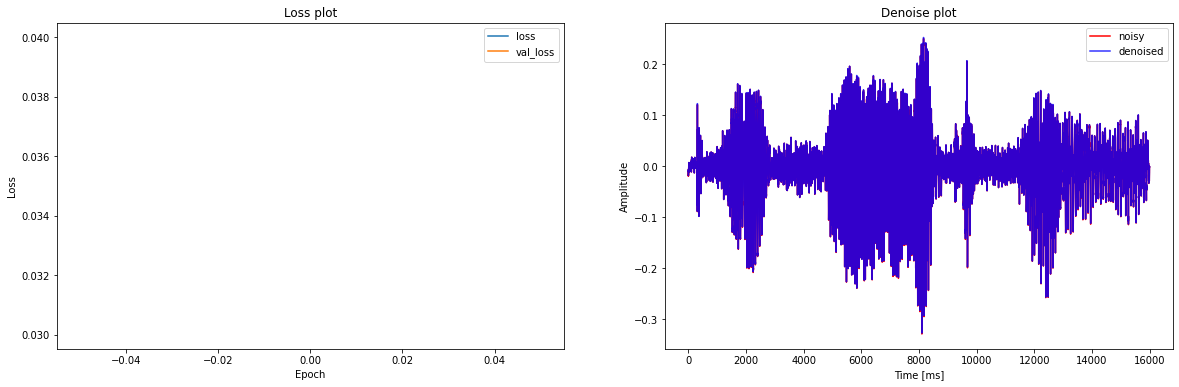

Epoch 2


In [ ]:
train_model(start_epoch = start_epoch, best = best,
            best_epoch = best_epoch, loaders = loaders,
            model = model, optimizer = optimizer,
            use_cuda = True)

In [ ]:
clean, noise, label = test_dataset[np.random.randint(len(test_dataset))]

In [ ]:
test_data.dataset[0]

(tensor([[ 0.0124,  0.0151,  0.0188,  ..., -0.0017,  0.0115,  0.0396]]),
 tensor([[ 0.0121,  0.0134,  0.0150,  ..., -0.0164,  0.0020,  0.0356]]),
 tensor(12))

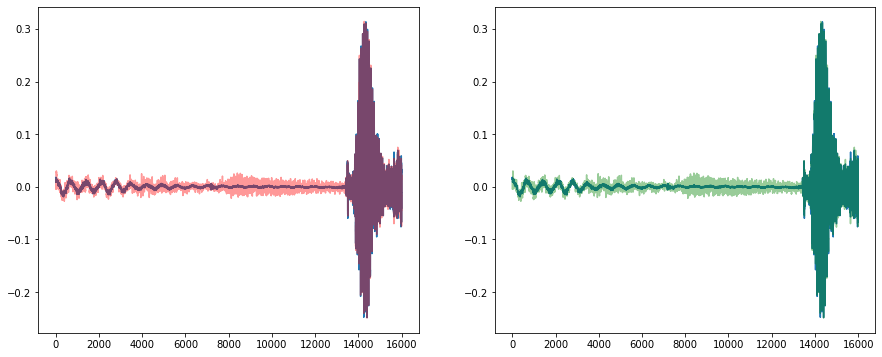

In [ ]:
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
plt.plot(clean.squeeze(0).numpy())
plt.plot(noise.squeeze(0).numpy(), color = 'red', alpha = .4)
plt.subplot(1, 2, 2)
plt.plot(clean.squeeze(0).numpy())
plt.plot(noise.squeeze(0).numpy(), color = 'green', alpha = .4)

In [ ]:
clean.squeeze(0).

torch.Size([16000])

In [ ]:
history = {}
history['train'] = []
history['validation'] = []

In [ ]:
history['train'].extend([.8])

In [ ]:
dirty

NameError: ignored

In [ ]:
idx = np.random.randint(len(test_data.dataset))
print(idx)
clean, dirty, _ = test_data.dataset[idx]
print(clean.size(), dirty.size())
dirty = dirty.unsqueeze(0).cuda()
print(dirty.size())
with torch.no_grad():
  denoised = model(dirty)
  

13
torch.Size([1, 16000]) torch.Size([1, 16000])
torch.Size([1, 1, 16000])


In [ ]:
denoised.size()

torch.Size([1, 1, 16000])

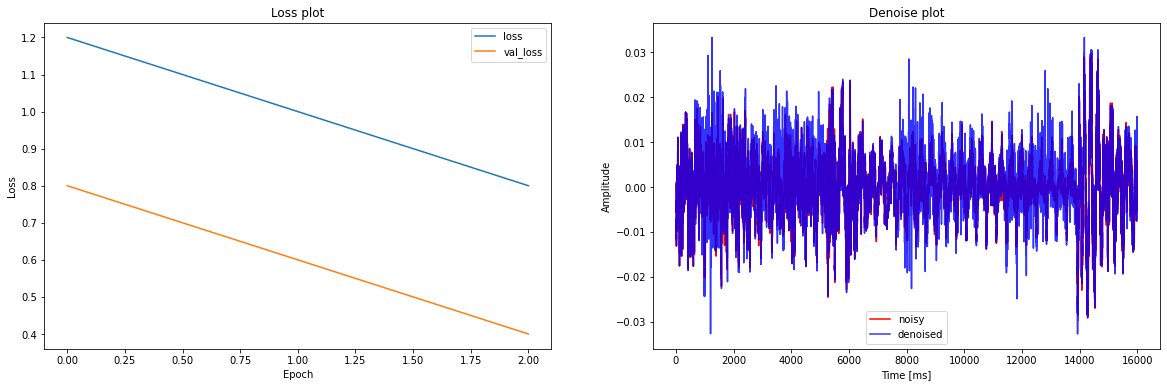

In [ ]:
plot_modelPerformance(history)

In [ ]:
history['train'] = [1.2]

In [ ]:
history['train']append(1.2)

SyntaxError: ignored

In [ ]:
!nvidia-smi

Fri Jun 12 17:13:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:83:00.0 Off |                    0 |
| N/A   72C    P0    59W / 149W |   8400MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000000:84:00.0 Off |                    0 |
| N/A   23C    P8    30W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

<hr>